Random forest algorithm for classifying the landsat image

In [2]:
#importing libraries

from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
from osgeo import gdal, osr, ogr
np.random.seed(0) #setting random seed
import matplotlib.pyplot as plt
import pickle 

**Processes starts from here**





In [3]:
#loading and reading pune data

pune22= gdal.Open('/content/drive/MyDrive/image_2022.tif',0)
bands=[]
for band in range(1,7):
  band_data=pune22.GetRasterBand(band).ReadAsArray()
  bands.append(band_data)

landsatData=np.stack(bands,axis=-1)

pune22=None #removing ds variable and releasing memory

In [4]:
landsatData0=np.nan_to_num(landsatData,nan=0) #assigning 0 for nan values
landsatData=None

In [5]:
#converting the nparray of landsat data to pandas dataframe by flattening

lsFlatten= landsatData0.reshape(-1,6)
flatDf=pd.DataFrame(data=lsFlatten,columns=['blue','green','red','nir','swir1','swir2'])
print(len(flatDf.index))
flatDf.head()

38018304


,blue,green,red,nir,swir1,swir2
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#now i have to make a pandas data frame with columns of 6 bands and labels
#then i have to split it into training and testing

#each column contains a np array of pixel value/reflectance value

In [6]:
#converting all training data into np array

#first, loading all training samples
#training data is given as tif files with 10 samples for each class

import glob
dataList=[]
folderPath='/content/drive/MyDrive/trainingData1'
fileList=sorted(glob.glob(folderPath+'/*.tif'))
for filePath in fileList:
  ds=gdal.Open(filePath)
  dataList.append(ds)
  ds=None



In [7]:
#converting each samples into np array
npDataList=[]
for i in dataList:
  tmpLst=[]
  for j in range(1,7):
    bnd=i.GetRasterBand(j).ReadAsArray()
    tmpLst.append(bnd)

  npDataList.append(np.stack(tmpLst,axis=-1))



In [8]:
print(len(npDataList)) #checking total no of samples

40


In [9]:
#converting training samples into dict with key is class name and value is the samples pixel values

classes=['blt','brn','veg','wtr','noData']
dataDict={}
n=0
cnt=0
for i in npDataList:
  shpAry=i.shape
  val=[]
  for j in range(0,shpAry[0]):
    for k in range(0,shpAry[1]):
      val.append(list(i[j,k,:]))


  dataDict.update({classes[n]:val})

  if (cnt+1)%10==0:
    n+=1

  cnt+=1

  
  


In [10]:
#assigning dictionary of samples into pandas dataframe for training

dfTrain=pd.DataFrame(columns=['label','blue','green','red','nir','swir1','swir2'])
pv=0
for p in range(0,len(dataDict)):
  clsName=list(dataDict.keys())[p]
  for q in range(0,len(dataDict[clsName])):
    itm=dataDict[clsName][q]
    data={'label':clsName,
      'blue':itm[0], 
      'green':itm[1], 
      'red':itm[2], 
      'nir':itm[3], 
      'swir1':itm[4], 
      'swir2':itm[5]
      }
    pv+=1
    dfTrain.loc[pv]=data


In [11]:
dfTrain.head() #printing and checking

,label,blue,green,red,nir,swir1,swir2
1,blt,8418.5,9151.5,8985.5,12472.0,11209.0,9824.0
2,blt,8487.0,9210.0,9020.0,11381.0,10877.5,9851.0
3,blt,8487.0,9210.0,9020.0,11381.0,10877.5,9851.0
4,blt,8783.0,9593.0,9274.5,13079.5,11728.0,10255.5
5,blt,8996.0,9827.5,9771.0,12770.0,12070.5,10651.5


In [12]:
#adding data into training dataframe for 0 values for identifying it as noData class

for s in range(1,51):
  r=len(dfTrain.index)+s
  data0={'label':classes[4],
      'blue':0.0, 
      'green':0.0, 
      'red':0.0, 
      'nir':0.0, 
      'swir1':0.0, 
      'swir2':0.0
      }
  dfTrain.loc[r]=data0

In [13]:
dfTrain['is_train']=np.random.uniform(0,1,len(dfTrain))<=.75  #dividing into train and test samples
dfTrain.head()

,label,blue,green,red,nir,swir1,swir2,is_train
1,blt,8418.5,9151.5,8985.5,12472.0,11209.0,9824.0,True
2,blt,8487.0,9210.0,9020.0,11381.0,10877.5,9851.0,True
3,blt,8487.0,9210.0,9020.0,11381.0,10877.5,9851.0,True
4,blt,8783.0,9593.0,9274.5,13079.5,11728.0,10255.5,True
5,blt,8996.0,9827.5,9771.0,12770.0,12070.5,10651.5,True


In [14]:
#creating dataframes with test rows and training rows
train,test=dfTrain[dfTrain['is_train']==True],dfTrain[dfTrain['is_train']==False]

#show the number of observations for the test and training dataframes
print('no: of obs in training data: ',len(train))
print('no: of obs in testing data: ',len(test))

no: of obs in training data:  8816
no: of obs in testing data:  2892


In [15]:
lab= pd.factorize(train["label"])[0]
lab
features=dfTrain.columns[1:7]  #creating feature vector for training from dataframe columns
features

Index(['blue', 'green', 'red', 'nir', 'swir1', 'swir2'], dtype='object')

In [16]:
#creating a random forest classifier

clf=RandomForestClassifier(n_jobs=2,n_estimators=200, random_state=50)
#Training the classifier
clf.fit(train[features],lab)

RandomForestClassifier(n_estimators=200, n_jobs=2, random_state=50)

In [17]:
clf.predict(test[features])  #predicting the test features

array([0, 0, 0, ..., 4, 4, 4])

In [18]:
clsAry=np.array(classes)
print(clsAry)

['blt' 'brn' 'veg' 'wtr' 'noData']


In [19]:
preds=clsAry[clf.predict(test[features])]
preds

array(['blt', 'blt', 'blt', ..., 'noData', 'noData', 'noData'],
      dtype='<U6')

In [20]:
pd.crosstab(test['label'],preds,rownames=['actual labels'],colnames=['predicted labels'])  #creating confusion matrix out of test data

predicted labels,blt,brn,noData,veg,wtr
actual labels,,,,,
blt,79,1,0,46,0
brn,0,841,0,17,0
noData,0,0,11,0,0
veg,8,12,0,1869,1
wtr,0,0,0,1,6


In [21]:
predFinal=clf.predict(flatDf)  #predicitng on our input satellite image data (here pune data)
predFinal

array([4, 4, 4, ..., 4, 4, 4])

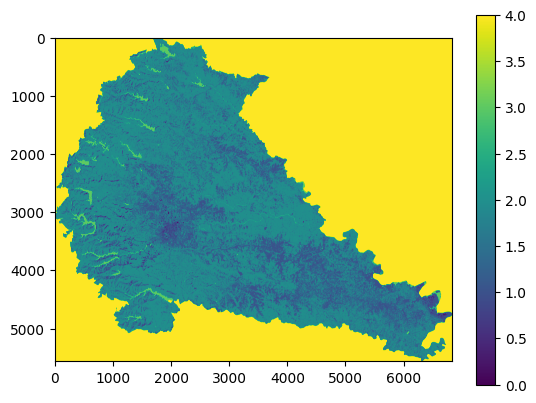

In [22]:
predFinal=predFinal.reshape(5568,6828)
plt.imshow(predFinal)
plt.colorbar()

In [ ]:
output_file = "/content/drive/MyDrive/pune22_rf_2"
driver = gdal.GetDriverByName("GTiff")

# get the spatial reference system of the data (optional)
srs = osr.SpatialReference()
srs.ImportFromEPSG(4326)  # set to WGS84

# create a new GeoTIFF file with one band
dst_ds = driver.Create(output_file, predFinal.shape[1], predFinal.shape[0], 1, gdal.GDT_Float32)

# set the projection (optional)
dst_ds.SetProjection(srs.ExportToWkt())

# write the data to the GeoTIFF file
dst_ds.GetRasterBand(1).WriteArray(predFinal)

# close the file
dst_ds = None

In [23]:
modelName="/content/drive/MyDrive/BigGeoProj/rf2.sav"
pickle.dump(clf, open(modelName, 'wb'))

In [24]:
clf=None
predFinal=None
test=None
train=None
dfTrain=None